In [1]:
# cell 1 – core libraries (keep it lean)
import math, json
from typing import Tuple, Literal, List, Dict

import numpy as np
import geopandas as gpd
from shapely.geometry import shape, Polygon, Point
from shapely.ops import unary_union
from pyproj import CRS


In [2]:
# cell 2 – helper: pick a sensible metric CRS (UTM zone for the polygon's centroid)
def utm_for_geometry(geom):
    """Pick the UTM zone that contains *geom*’s centroid."""
    lon, lat = geom.centroid.x, geom.centroid.y
    zone = int((lon + 180) // 6) + 1
    south = lat < 0
    return f"EPSG:{32700 + zone if south else 32600 + zone}"

In [3]:
# ── cell 3 ────────────────────────────────────────────────────────────────────
def hex_tile(
    aoi_geojson: Dict,
    scale: float = 1.0,
    hex_diam: float = 250,                     # metres (circumscribed)
    projection: str | None = None,             # None → auto-UTM
    orientation: Literal["flat", "pointy"] = "pointy",
    keep_rule: Literal["intersect", "centroid"] = "intersect"
) -> Tuple[gpd.GeoDataFrame, gpd.GeoDataFrame]:
    """
    Return a hex-grid that fully covers *aoi_geojson*.

    hex_diam  :   vertex-to-vertex distance *before* scaling
    scale     :   simple multiplier on the diameter
    """
    # --- prep: AOI → projected CRS ------------------------------------------
    aoi_wgs   = shape(aoi_geojson)
    proj_crs  = CRS.from_user_input(projection or utm_for_geometry(aoi_wgs))
    aoi_geom  = gpd.GeoSeries([aoi_wgs], crs=4326).to_crs(proj_crs).iloc[0]

    r = (hex_diam * scale) / 2.0                      # circumscribed radius

    # --- choose lattice basis vectors a, b  ---------------------------------
    if orientation == "flat":                         # flat-topped
        a = np.array([1.5 * r,  np.sqrt(3)/2 * r])    # right-down
        b = np.array([0.0    ,  np.sqrt(3)   * r])    # straight down
        rot = 0
    else:                                             # pointy-topped
        a = np.array([np.sqrt(3)   * r, 0.0])         # right
        b = np.array([np.sqrt(3)/2 * r, 1.5 * r])     # down-right
        rot = 30

    # matrix for  (i,j) → (x,y)    and its inverse for (x,y) → (i,j)
    M      = np.column_stack((a, b))                  # 2×2
    M_inv  = np.linalg.inv(M)

    # --- find index range that covers the AOI bbox (+ one hex margin) -------
    minx, miny, maxx, maxy = aoi_geom.bounds
    pad = r * 2                                       # generous margin
    corners = np.array([[minx-pad, miny-pad],
                        [minx-pad, maxy+pad],
                        [maxx+pad, miny-pad],
                        [maxx+pad, maxy+pad]])
    ij_corners = (M_inv @ corners.T).T                # shape (4,2)

    i_min, j_min = np.floor(ij_corners.min(axis=0) - 2).astype(int)
    i_max, j_max = np.ceil (ij_corners.max(axis=0) + 2).astype(int)

    # --- build hexagons ------------------------------------------------------
    def centroid(i: int, j: int) -> np.ndarray:
        return M @ np.array([i, j])

    angles = np.deg2rad(np.arange(0, 360, 60) + rot)

    hexes_xy = []          # store vertices for GeoDataFrame
    for i in range(i_min, i_max + 1):
        for j in range(j_min, j_max + 1):
            cx, cy = centroid(i, j)
            verts = [(cx + r*math.cos(t), cy + r*math.sin(t)) for t in angles]
            poly  = Polygon(verts)
            if keep_rule == "intersect":
                if not poly.intersects(aoi_geom):   # quick reject
                    continue
            else:  # centroid rule
                if not Point(cx, cy).within(aoi_geom):
                    continue
            hexes_xy.append(poly)

    hexes_gdf  = gpd.GeoDataFrame(geometry=hexes_xy, crs=proj_crs)
    outline_gdf = gpd.GeoDataFrame(
        geometry=[unary_union(hexes_gdf.geometry)], crs=proj_crs
    )

    return hexes_gdf.to_crs(4326), outline_gdf.to_crs(4326)


In [4]:
# cell 4
import matplotlib.pyplot as plt, contextily as ctx

def show_tiling(aoi_json, hexes, outline, landcover=None, title=""):
    aoi = gpd.GeoSeries([shape(aoi_json)], crs=4326)
    aoi3857      = aoi.to_crs(3857)
    hexes3857    = hexes.to_crs(3857)
    outline3857  = outline.to_crs(3857)
    land3857 = landcover.to_crs(3857) if landcover is not None else None

    fig, ax = plt.subplots(figsize=(7, 7))

    if land3857 is not None:
        land3857.plot(ax=ax, column="cover", alpha=.5,
                      legend=True, edgecolor="k", linewidth=.3)

    hexes3857.plot(ax=ax, facecolor="none", edgecolor="tab:orange", lw=.8)
    outline3857.boundary.plot(ax=ax, color="red", lw=1.2, linestyle="--")
    aoi3857.boundary.plot(ax=ax, color="black", lw=1.5, label="AOI")

    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, alpha=.35)
    ax.set_axis_off(); ax.set_title(title); ax.legend()
    plt.show()


In [5]:
# cell 5 – rectangle around Golden Gate Park, San Francisco
rect_poly = {            # ≈ 600 × 300 m rectangle, Venice Beach, CA
    "type": "Polygon",
    "coordinates": [[
        [-118.4712, 33.9864],
        [-118.4656, 33.9864],
        [-118.4656, 33.9891],
        [-118.4712, 33.9891],
        [-118.4712, 33.9864]
    ]]
}

irr_poly = {             # small diamond-like shape, Mojave
    "type": "Polygon",
    "coordinates": [[
        [-116.150, 35.040],
        [-116.135, 35.055],
        [-116.120, 35.040],
        [-116.135, 35.025],
        [-116.150, 35.040]
    ]]
}

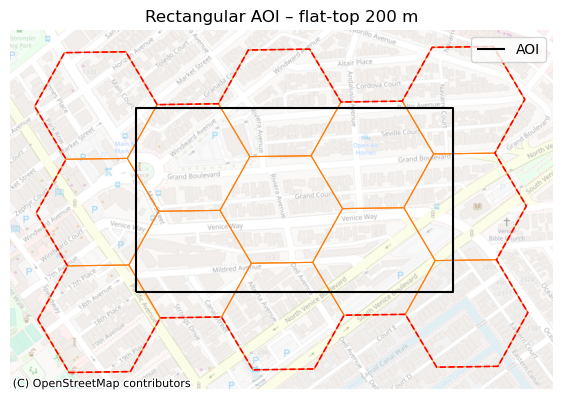

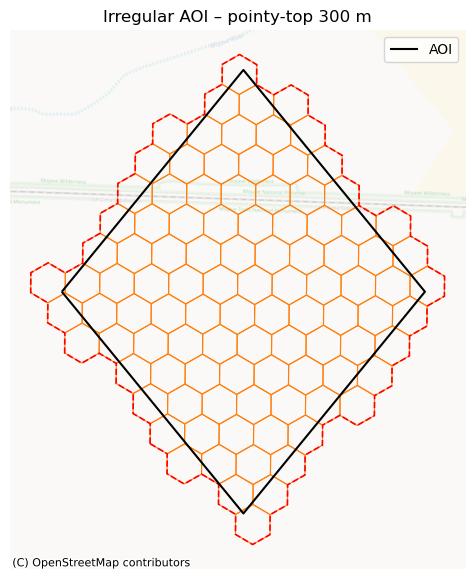

In [8]:
# rectangle – FLAT-topped
hex_r, out_r = hex_tile(rect_poly,
                        hex_diam=200,      # 200 m across
                        orientation="flat")
show_tiling(rect_poly, hex_r, out_r, title="Rectangular AOI – flat-top 200 m")

# irregular – POINTY-topped
hex_i, out_i = hex_tile(irr_poly,
                        hex_diam=300,
                        orientation="pointy")
show_tiling(irr_poly, hex_i, out_i, title="Irregular AOI – pointy-top 300 m")
